In [27]:
# Add parent directory to Python path to make src module accessible
import os
import sys

# Get the absolute path of the notebook directory
notebook_dir = os.path.abspath('')
print(f"Notebook directory: {notebook_dir}")

# Get the project root (two levels up from notebooks/t.k)
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
print(f"Project root: {project_root}")

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

# Define path to features module
features_path = os.path.join(project_root, 'src', 'features.py')
print(f"Features module path: {features_path}")

# Verify the features.py file exists
if os.path.exists(features_path):
    print(f"Features module exists at: {features_path}")
else:
    print(f"Warning: Features module not found at: {features_path}")

# Test the import now
try:
    from src.features import ConceptMatcher
    print("Successfully imported ConceptMatcher from src.features")
except ImportError as e:
    print(f"Import error: {e}")


Notebook directory: c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect\notebooks\t.k
Project root: c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect
c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect already in Python path
Features module path: c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect\src\features.py
Features module exists at: c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect\src\features.py
Successfully imported ConceptMatcher from src.features


# Career Path Prediction Model Implementation

This notebook demonstrates the implementation of an efficient machine learning model for predicting career paths based on technology skills.

In [28]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
# Load and prepare the data
def load_data(file_path="../../data/processed/clean_v3.csv"):
    """Load and prepare the Stack Overflow survey data."""
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")
    return df

# Load the dataset
df = load_data()
df.head(2)

Loaded dataset with shape: (45377, 9)


,YearsCode,DevType,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,EmbeddedHaveWorkedWith,MiscTechHaveWorkedWith,ToolsTechHaveWorkedWith
0,20,"Developer, full-stack",Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,Express;Next.js;Node.js;React,NaN,NaN,Docker;Homebrew;Kubernetes;npm;Vite;Webpack
1,4,"Developer, full-stack",C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...,MongoDB;MySQL;PostgreSQL;SQLite,Amazon Web Services (AWS);Fly.io;Heroku,jQuery;Next.js;Node.js;React;WordPress,Rasberry Pi,NumPy;Pandas;Ruff;TensorFlow,Docker;npm;Pip


## Data Preprocessing

We need to preprocess the data to prepare it for model training. This includes handling the `YearsCode` column properly as a numerical feature.

In [30]:
# Check if YearsCode column exists
if 'YearsCode' in df.columns:
    print("YearsCode column exists. Checking value distribution...")
    print(df['YearsCode'].value_counts().head(10))
    print(f"Data type: {df['YearsCode'].dtype}")
else:
    print("YearsCode column not found!")

YearsCode column exists. Checking value distribution...
YearsCode
10    3593
8     2635
6     2517
5     2512
7     2473
15    2360
20    2140
12    2101
4     2035
9     1814
Name: count, dtype: int64
Data type: object


YearsCode converted to numeric. Median value: 12.0


C:\Users\Tayeb Kahia\AppData\Local\Temp\ipykernel_9904\1097975889.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['YearsCode'].fillna(median_years, inplace=True)


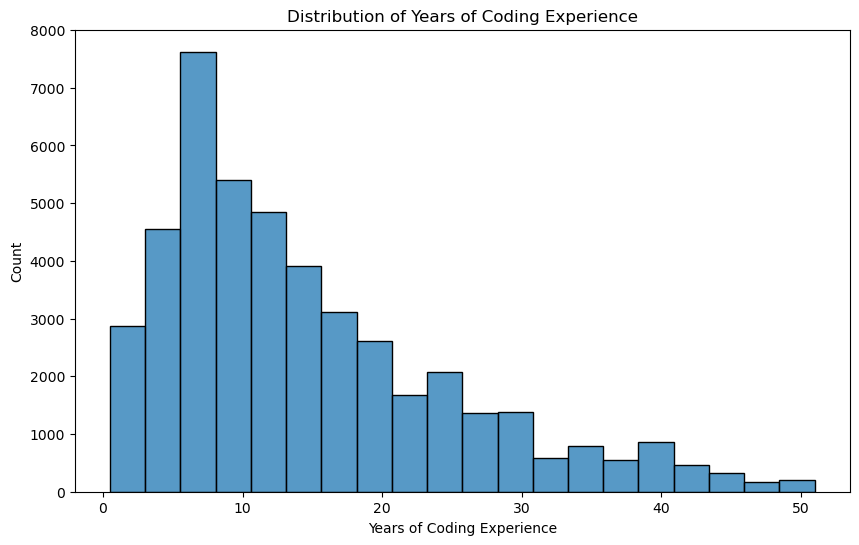

In [31]:
# Handle YearsCode column - convert to numeric
def preprocess_years_code(df):
    """Convert YearsCode column to numeric values."""
    if 'YearsCode' in df.columns:
        # Make a copy to avoid warning
        df = df.copy()
        
        # Replace text values with numeric equivalents
        df['YearsCode'] = df['YearsCode'].replace('Less than 1 year', '0.5')
        df['YearsCode'] = df['YearsCode'].replace('More than 50 years', '51')
        
        # Convert to numeric and handle errors
        df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce')
        
        # Fill missing values with median
        median_years = df['YearsCode'].median()
        df['YearsCode'].fillna(median_years, inplace=True)
        
        print(f"YearsCode converted to numeric. Median value: {median_years}")
    return df

# Preprocess YearsCode column
df = preprocess_years_code(df)

# Visualize YearsCode distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['YearsCode'], bins=20)
plt.title('Distribution of Years of Coding Experience')
plt.xlabel('Years of Coding Experience')
plt.ylabel('Count')
plt.show()

In [32]:
# Define the technology columns and target column
TECH_COLUMNS = [
    "LanguageHaveWorkedWith", 
    "DatabaseHaveWorkedWith", 
    "PlatformHaveWorkedWith",
    "WebframeHaveWorkedWith", 
    "MiscTechHaveWorkedWith",
    "ToolsTechHaveWorkedWith"
]
TARGET_COLUMN = "DevType"

# Process technology columns (convert from semicolon-separated strings to lists)
def process_tech_columns(df, tech_columns=TECH_COLUMNS):
    """Process technology columns by splitting semicolon-separated values."""
    df = df.copy()
    for col in tech_columns:
        if col in df.columns:
            df[col] = df[col].fillna('').apply(
                lambda x: [tech.strip() for tech in x.split(';')] if x else []
            )
    return df

# Process technology columns
df = process_tech_columns(df)

# Check a sample of processed data
print("Sample of processed technology columns:")
for col in TECH_COLUMNS[:2]:  # Just show first 2 columns as example
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].head(2))

Sample of processed technology columns:

LanguageHaveWorkedWith:
0    [Bash/Shell (all shells), Go, HTML/CSS, Java, ...
1    [C, C++, HTML/CSS, Java, JavaScript, PHP, Powe...
Name: LanguageHaveWorkedWith, dtype: object

DatabaseHaveWorkedWith:
0         [Dynamodb, MongoDB, PostgreSQL]
1    [MongoDB, MySQL, PostgreSQL, SQLite]
Name: DatabaseHaveWorkedWith, dtype: object


In [33]:
# Extract unique career paths from the DevType column
def extract_career_paths(df, target_col=TARGET_COLUMN):
    """Extract unique career paths from the target column."""
    if target_col in df.columns:
        # Split semicolon-separated values and flatten the list
        all_devtypes = []
        for devtypes_str in df[target_col].fillna('').tolist():
            devtypes = [devtype.strip() for devtype in devtypes_str.split(';')] if devtypes_str else []
            all_devtypes.extend(devtypes)
            
        # Remove empty strings and duplicates
        career_paths = sorted(set(path for path in all_devtypes if path))
        print(f"Found {len(career_paths)} unique career paths")
        print(f"First 5 career paths: {career_paths[:5]}")
        
        # Count occurrences of each path to verify distribution
        from collections import Counter
        path_counts = Counter(all_devtypes)
        print(f"Top 5 most common paths: {path_counts.most_common(5)}")
        
        return career_paths
    return []

# Get unique career paths
career_paths = extract_career_paths(df)
print("\nSample career paths:")
career_paths

Found 21 unique career paths
First 5 career paths: ['Blockchain', 'Cloud infrastructure engineer', 'Data engineer', 'Data or business analyst', 'Data scientist or machine learning specialist']
Top 5 most common paths: [('Developer, full-stack', 17764), ('Developer, back-end', 9635), ('Developer, front-end', 3229), ('Developer, desktop or enterprise applications', 2430), ('Developer, mobile', 1956)]

Sample career paths:


['Blockchain',
 'Cloud infrastructure engineer',
 'Data engineer',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'DevOps specialist',
 'Developer, AI',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',
 'Developer, embedded applications or devices',
 'Developer, front-end',
 'Developer, full-stack',
 'Developer, game or graphics',
 'Developer, mobile',
 'Engineering manager',
 'Hardware Engineer',
 'Product manager',
 'Project manager',
 'Security professional',
 'System administrator']

## Feature Engineering

We'll now create features from the technology columns and the YearsCode column.

In [34]:
# One-hot encode technology columns
def one_hot_encode_tech(df, tech_columns=TECH_COLUMNS):
    """One-hot encode the technology columns using MultiLabelBinarizer."""
    # Combine all technology lists for fitting the MultiLabelBinarizer
    all_techs = []
    for col in tech_columns:
        if col in df.columns:
            all_techs.extend([tech for techs in df[col] for tech in techs if tech])
    
    unique_techs = sorted(set(all_techs))
    mlb = MultiLabelBinarizer(classes=unique_techs)
    mlb.fit([unique_techs])
    
    tech_features_df = pd.DataFrame()
    for col in tech_columns:
        if col in df.columns:
            # Transform the list column into one-hot encoded columns
            col_encoded = mlb.transform(df[col])
            col_df = pd.DataFrame(
                col_encoded, 
                columns=[f"{tech}" for tech in mlb.classes_],
                index=df.index
            )
            tech_features_df = pd.concat([tech_features_df, col_df], axis=1)
    
    # Handle duplicate columns by taking the maximum value
    tech_features_df = tech_features_df.groupby(tech_features_df.columns, axis=1).max()
    
    print(f"Created {tech_features_df.shape[1]} technology features")
    return tech_features_df, mlb

# Get one-hot encoded tech features
tech_features, mlb = one_hot_encode_tech(df)

# Display a sample of the encoded features
print("\nSample of one-hot encoded technology features:")
print(tech_features.iloc[:2, :10])  # Show first 2 rows and 10 columns

C:\Users\Tayeb Kahia\AppData\Local\Temp\ipykernel_9904\3593742744.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tech_features_df = tech_features_df.groupby(tech_features_df.columns, axis=1).max()


Created 219 technology features

Sample of one-hot encoded technology features:
   .NET (5+)  .NET Framework (1.0 - 4.8)  .NET MAUI  APT  ASP.NET  \
0          0                           0          0    0        0   
1          0                           0          0    0        0   

   ASP.NET CORE  Ada  Alibaba Cloud  Amazon Web Services (AWS)  Angular  
0             0    0              0                          1        0  
1             0    0              0                          1        0  


In [35]:
# Prepare features and target
def prepare_features_target(df, tech_features, target_col=TARGET_COLUMN):
    """Prepare final features (excluding YearsCode) and target for model training."""
    # Use tech features directly as X
    X = tech_features
    
    # Prepare target variable
    y = None
    if target_col in df.columns:
        # Process the target column into a list of lists
        y = df[target_col].fillna('').apply(
            lambda x: [devtype.strip() for devtype in x.split(';')] if x else []
        ).tolist()
        
        # Add diagnostics to help debug
        empty_targets = sum(1 for item in y if len(item) == 0)
        total_samples = len(y)
        avg_paths = sum(len(item) for item in y) / max(total_samples, 1)
        
        print(f"Target variable prepared: {total_samples} samples total")
        print(f"Empty career paths: {empty_targets} ({empty_targets/total_samples*100:.1f}% of samples)")
        print(f"Average career paths per person: {avg_paths:.2f}")
        
        if y and len(y) > 0:
            print(f"First example has {len(y[0])} career paths: {y[0][:3]}" + ("..." if len(y[0]) > 3 else ""))
    
    return X, y

# Get features and target
X, y = prepare_features_target(df, tech_features)

# Display feature information
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable length: {len(y)}")  # Changed to use len() for list
print("\nFeature columns (sample):") 
print(X.columns[:10])  # Show first 10 columns as sample

Target variable prepared: 45377 samples total
Empty career paths: 0 (0.0% of samples)
Average career paths per person: 1.00
First example has 1 career paths: ['Developer, full-stack']

Feature matrix shape: (45377, 219)
Target variable length: 45377

Feature columns (sample):
Index(['.NET (5+)', '.NET Framework (1.0 - 4.8)', '.NET MAUI', 'APT',
       'ASP.NET', 'ASP.NET CORE', 'Ada', 'Alibaba Cloud',
       'Amazon Web Services (AWS)', 'Angular'],
      dtype='object')


Target variable type: <class 'list'>
First 3 items in target variable: [['Developer, full-stack'], ['Developer, full-stack'], ['Developer, full-stack']]
Target encoded with 21 classes
Class counts: [  224   612  1091   502   995   163   996   509  9635  2430  1592  3229
 17764   690  1956  1248   194   280   401   345   521]
Class distribution: Most common class has 17764 samples, least common (non-zero) has 163 samples

Training data shape: (36301, 219), (36301, 21)
Test data shape: (9076, 219), (9076, 21)


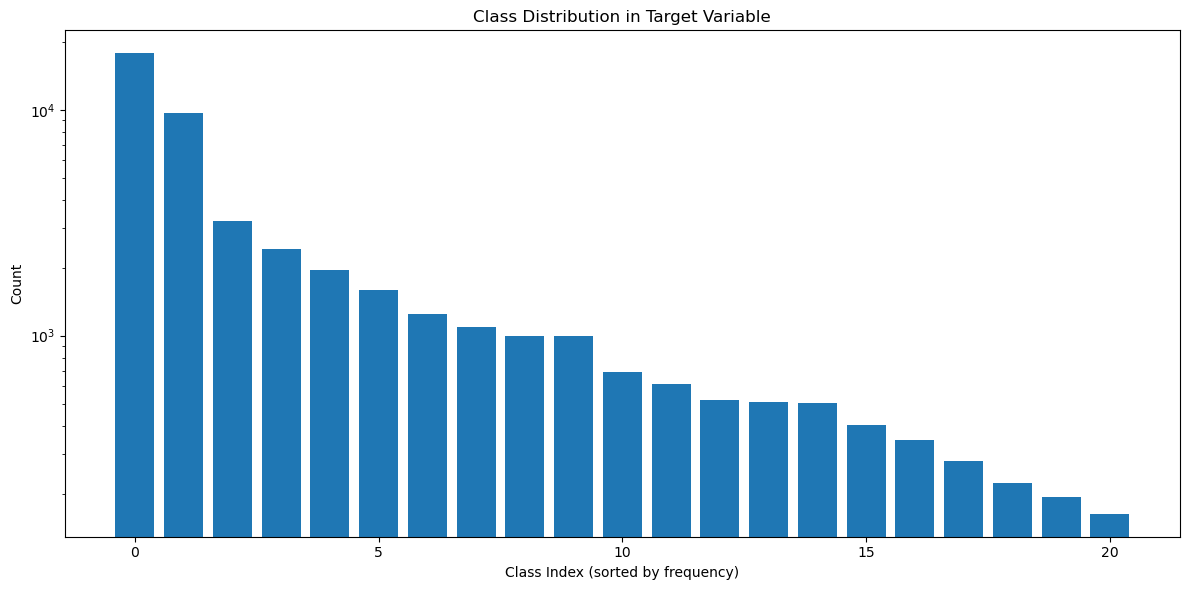


Top 5 most common career paths:
Developer, full-stack: 17764 samples (weight: 0.1216)
Developer, back-end: 9635 samples (weight: 0.2243)
Developer, front-end: 3229 samples (weight: 0.6692)
Developer, desktop or enterprise applications: 2430 samples (weight: 0.8892)
Developer, mobile: 1956 samples (weight: 1.1047)

Top 5 least common career paths:
Database administrator: 163 samples (weight: 13.2565)
Hardware Engineer: 194 samples (weight: 11.1382)
Blockchain: 224 samples (weight: 9.6465)
Product manager: 280 samples (weight: 7.7172)
Security professional: 345 samples (weight: 6.2632)


In [36]:
# One-hot encode the target variable
def encode_target(y, career_paths=None):
    """One-hot encode the target variable using MultiLabelBinarizer and calculate class weights."""
    # Debug information
    print(f"Target variable type: {type(y)}")
    print(f"First 3 items in target variable: {y[:3]}")
    
    if career_paths is None:
        target_mlb = MultiLabelBinarizer()
        y_encoded = target_mlb.fit_transform(y)
    else:
        target_mlb = MultiLabelBinarizer(classes=career_paths)
        y_encoded = target_mlb.fit_transform(y)
    
    # Calculate class weights to handle imbalance
    class_counts = y_encoded.sum(axis=0)
    total_samples = len(y_encoded)
    class_weights = {}
    
    print(f"Target encoded with {y_encoded.shape[1]} classes")
    print(f"Class counts: {class_counts}")
    
    # Add a small sanity check to ensure all classes have at least a few samples
    if min(class_counts) == 0:
        print("Warning: Some classes have 0 samples. This may affect model training.")
        print(f"Number of classes with 0 samples: {np.sum(class_counts == 0)}")
    
    # Handle class weights carefully
    for i, count in enumerate(class_counts):
        # More weight to less frequent classes (inverse frequency)
        # Use max(count, 1) to avoid division by zero
        if count == 0:
            # For classes with no samples, assign a reasonable but not extreme weight
            class_weights[i] = total_samples / len(class_counts)  # Use average weight
        else:
            class_weights[i] = total_samples / (len(class_counts) * count)
    
    # Print distribution information
    non_zero_counts = class_counts[class_counts > 0]
    if len(non_zero_counts) > 0:
        print(f"Class distribution: Most common class has {max(class_counts)} samples, least common (non-zero) has {min(non_zero_counts)} samples")
    else:
        print("Class distribution: All classes have 0 samples, which is unexpected")
    
    return y_encoded, target_mlb, class_weights

# Encode the target
y_encoded, target_mlb, class_weights = encode_target(y, career_paths)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print(f"\nTraining data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Visualize class distribution
class_counts = y_encoded.sum(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_counts)), sorted(class_counts, reverse=True))
plt.title('Class Distribution in Target Variable')
plt.xlabel('Class Index (sorted by frequency)')
plt.ylabel('Count')
plt.yscale('log')  # Log scale to better visualize the imbalance
plt.tight_layout()
plt.show()

# Show the top 5 most common and 5 least common classes
top_indices = np.argsort(-class_counts)[:5]
bottom_indices = np.argsort(class_counts)[:5]

print("\nTop 5 most common career paths:")
for idx in top_indices:
    print(f"{career_paths[idx]}: {class_counts[idx]} samples (weight: {class_weights[idx]:.4f})")

print("\nTop 5 least common career paths:")
for idx in bottom_indices:
    print(f"{career_paths[idx]}: {class_counts[idx]} samples (weight: {class_weights[idx]:.4f})")

In [37]:
# Implement a deep learning model for tech skills only
def build_model(input_dim, num_classes):
    """Build a model that processes tech skills only."""
    # Tech input
    inputs = Input(shape=(input_dim,), name='tech_input')
    x = Dense(512, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Get dimensions for the model
input_dim = X_train.shape[1]
num_classes = y_train.shape[1]

# Build the model
model = build_model(input_dim, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tech_input (InputLayer)         │ (None, 219)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       112,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,573 (1.07 MB)

 Trainable params: 279,573 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Prepare inputs for the model (no need to separate YearsCode anymore)
X_train_tech = X_train.values
X_test_tech = X_test.values

# Define callbacks for early stopping based on convergence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Early stopping to prevent overfitting and stop after convergence
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=10,             # Number of epochs with no improvement after which training will stop
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1                # Show messages
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.2,              # Factor by which the learning rate will be reduced
    patience=5,              # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001,           # Lower bound on the learning rate
    verbose=1                # Show messages
)

# Create a checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',      # Path to save the model
    monitor='val_loss',      # Quantity to monitor
    save_best_only=True,     # Only save a model if `val_loss` has improved
    verbose=1                # Show messages
)

# Train the model with class weights and early stopping
history = model.fit(
    X_train_tech, y_train,
    epochs=200,               # Maximum number of epochs (will likely stop earlier due to early stopping)
    batch_size=64,
    validation_data=(X_test_tech, y_test),
    class_weight=class_weights, # Apply class weights to handle imbalance
    callbacks=[early_stopping, reduce_lr, checkpoint], # Add callbacks for convergence-based stopping
    verbose=1
)

Epoch 1/200
555/568 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1522 - loss: 0.2231
Epoch 1: val_loss improved from inf to 0.15566, saving model to best_model.keras

Epoch 1: val_loss improved from inf to 0.15566, saving model to best_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1542 - loss: 0.2219 - val_accuracy: 0.2762 - val_loss: 0.1557 - learning_rate: 0.0010
Epoch 2/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1542 - loss: 0.2219 - val_accuracy: 0.2762 - val_loss: 0.1557 - learning_rate: 0.0010
Epoch 2/200
560/568 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3082 - loss: 0.1431
Epoch 2: val_loss improved from 0.15566 to 0.15312, saving model to best_model.keras

Epoch 2: val_loss improved from 0.15566 to 0.15312, saving model to best_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3084 - loss: 0.1430 - val_accuracy: 0.2857 - val_loss: 0.1531 - learning_rate: 0.0010
Epoch 3/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - ac

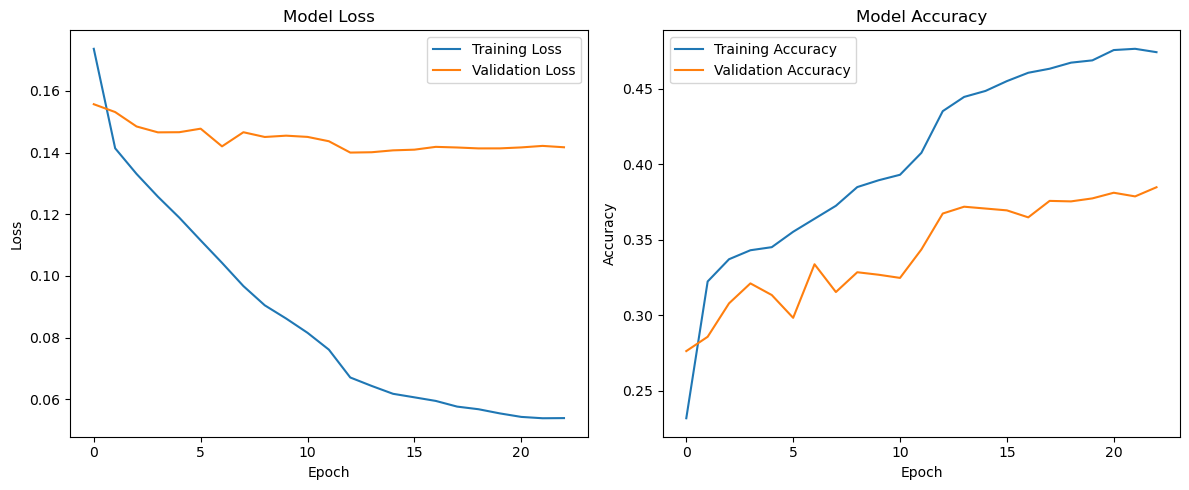

In [39]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# Evaluate the model with adjusted thresholds for imbalanced classes
def evaluate_model(model, X_test_tech, y_test, target_mlb):
    """Evaluate the model performance with adjusted thresholds for imbalanced classes."""
    # Get predictions
    y_pred_proba = model.predict(X_test_tech)
    
    # Calculate class-specific thresholds based on validation set
    class_counts = y_test.sum(axis=0)
    total_samples = len(y_test)
    
    # Option 1: Use fixed threshold of 0.5
    y_pred_fixed = (y_pred_proba > 0.5).astype(int)
    
    # Option 2: Use adjusted thresholds based on class frequency
    # Lower thresholds for rare classes, higher for common ones
    adjusted_thresholds = []
    for count in class_counts:
        # Classes with fewer samples get lower thresholds
        # Scale the threshold between 0.3 and 0.5 based on frequency
        threshold = 0.3 + 0.2 * (count / max(class_counts))
        adjusted_thresholds.append(threshold)
    
    adjusted_thresholds = np.array(adjusted_thresholds)
    y_pred_adjusted = (y_pred_proba > adjusted_thresholds).astype(int)
    
    # Calculate metrics for both methods
    accuracy_fixed = accuracy_score(y_test, y_pred_fixed)
    micro_f1_fixed = f1_score(y_test, y_pred_fixed, average='micro')
    macro_f1_fixed = f1_score(y_test, y_pred_fixed, average='macro')
    
    accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
    micro_f1_adjusted = f1_score(y_test, y_pred_adjusted, average='micro')
    macro_f1_adjusted = f1_score(y_test, y_pred_adjusted, average='macro')
    
    print("\nWith fixed threshold (0.5):")
    print(f"Accuracy: {accuracy_fixed:.4f}")
    print(f"Micro-F1: {micro_f1_fixed:.4f}")
    print(f"Macro-F1: {macro_f1_fixed:.4f}")
    
    print("\nWith adjusted thresholds (based on class frequency):")
    print(f"Accuracy: {accuracy_adjusted:.4f}")
    print(f"Micro-F1: {micro_f1_adjusted:.4f}")
    print(f"Macro-F1: {macro_f1_adjusted:.4f}")
    
    # Choose the better prediction method based on macro-F1
    if macro_f1_adjusted > macro_f1_fixed:
        y_pred = y_pred_adjusted
        print("\nUsing adjusted thresholds for final evaluation (better macro-F1)")
    else:
        y_pred = y_pred_fixed
        print("\nUsing fixed threshold for final evaluation (better macro-F1)")
    
    # Show the top classes with highest positive counts
    class_counts = y_pred.sum(axis=0)
    class_names = target_mlb.classes_
    
    top_indices = np.argsort(-class_counts)[:10]  # Top 10 classes
    print("\nTop 10 predicted career paths:")
    for idx in top_indices:
        print(f"{class_names[idx]}: {class_counts[idx]} predictions")
    
    # Analyze performance for most imbalanced classes
    rare_class_indices = np.argsort(y_test.sum(axis=0))[:5]  # 5 rarest classes
    print("\nPerformance on 5 rarest classes:")
    for idx in rare_class_indices:
        y_true_class = y_test[:, idx]
        y_pred_class = y_pred[:, idx]
        recall = recall_score(y_true_class, y_pred_class)
        precision = precision_score(y_true_class, y_pred_class, zero_division=0)
        f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
        print(f"{class_names[idx]}: Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}")
    
    return y_pred, y_pred_proba

# Import additional metrics
from sklearn.metrics import recall_score, precision_score

# Evaluate the model
y_pred, y_pred_proba = evaluate_model(model, X_test_tech, y_test, target_mlb)

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

With fixed threshold (0.5):
Accuracy: 0.1857
Micro-F1: 0.2626
Macro-F1: 0.2502

With adjusted thresholds (based on class frequency):
Accuracy: 0.1976
Micro-F1: 0.2755
Macro-F1: 0.2552

Using adjusted thresholds for final evaluation (better macro-F1)

With fixed threshold (0.5):
Accuracy: 0.1857
Micro-F1: 0.2626
Macro-F1: 0.2502

With adjusted thresholds (based on class frequency):
Accuracy: 0.1976
Micro-F1: 0.2755
Macro-F1: 0.2552

Using adjusted thresholds for final evaluation (better macro-F1)

Top 10 predicted career paths:
Developer, front-end: 1150 predictions
Engineering manager: 679 predictions
Developer, desktop or enterprise applications: 657 predictions
Developer, mobile: 642 predictions
Developer, back-end: 606 predictions
DevOps specialist: 460 predictions
Developer, embedded applications or devices: 420 predictions
Data engineer: 320 predictions
Developer, AI: 278 predictions
Developer, game

## Save Model and Related Components

Now we'll save the model and related components for use in the FastAPI backend.

In [41]:
# Save the model and related components including class weights and thresholds
def save_model(model, mlb, target_mlb, class_weights, save_dir="../models"):
    """Save the model and related components."""
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the model with proper file extension (.keras or .h5)
    model_path = os.path.join(save_dir, "career_path_model.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Calculate class-specific thresholds based on class frequency
    class_counts = np.array([class_weights[i] for i in range(len(class_weights))])
    adjusted_thresholds = np.zeros(len(class_counts))
    for i, weight in enumerate(class_counts):
        # Inverse relationship between weight and threshold - higher weight = lower threshold
        # Scale between 0.3 and 0.5
        min_threshold = 0.3
        max_threshold = 0.5
        normalized_weight = (weight - min(class_counts)) / (max(class_counts) - min(class_counts))
        adjusted_thresholds[i] = max_threshold - normalized_weight * (max_threshold - min_threshold)
    
    # Save components needed for preprocessing and postprocessing
    components = {
        'tech_mlb': mlb,
        'target_mlb': target_mlb,
        'career_paths': list(target_mlb.classes_),
        'class_weights': class_weights,
        'adjusted_thresholds': adjusted_thresholds.tolist()
    }
    
    components_path = os.path.join(save_dir, "model_components.joblib")
    joblib.dump(components, components_path)
    print(f"Model components saved to {components_path}")
    
# Save the model and components
save_model(model, mlb, target_mlb, class_weights)

Model saved to ../models\career_path_model.keras
Model components saved to ../models\model_components.joblib


In [43]:
# Test model loading and prediction with class-weighted prediction
import os
def test_model_loading(model_dir="../models", sample_text=None):
    """Test loading the model and making predictions."""
    # Load model
    model_path = os.path.join(model_dir, "career_path_model.keras")
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Load components
    components_path = os.path.join(model_dir, "model_components.joblib")
    components = joblib.load(components_path)
    
    tech_mlb = components['tech_mlb']
    target_mlb = components['target_mlb']
    career_paths = components['career_paths']
    
    # Get class-specific thresholds if available
    if 'adjusted_thresholds' in components:
        adjusted_thresholds = components['adjusted_thresholds']
        print(f"Loaded adjusted thresholds for {len(adjusted_thresholds)} classes")
    else:
        adjusted_thresholds = None
        print("No adjusted thresholds found, will use fixed threshold of 0.5")
    
    print(f"Model loaded successfully. Can predict {len(career_paths)} career paths.")
    
    # If a sample text is provided, demonstrate prediction
    if sample_text:
        # Import is now safe since we added the project root to sys.path above
        from src.features import ConceptMatcher
        
        # Create an absolute path to the CSV file
        csv_path = os.path.join(project_root, 'data', 'processed', 'technologies_with_abbreviations.csv')
        print(f"Using technologies CSV file: {csv_path}")
        
        # Create the ConceptMatcher with the absolute path
        matcher = ConceptMatcher(csv_path=csv_path)
        
        try:
            matcher.load_concepts()
            matcher.generate_concept_embeddings(load_if_exists=True)
            
            # Extract technologies from text
            matcher.prepare_candidate_phrases(sample_text)
            matcher.vectorized_match_candidates()
            matcher.global_filtering()
            
            # Get recognized technologies
            recognized_techs = matcher.get_recognized_technologies()
            print(f"\nRecognized technologies: {recognized_techs}")
            
            # Prepare features
            tech_features = pd.DataFrame(np.zeros((1, len(tech_mlb.classes_))), columns=tech_mlb.classes_)
            for tech in recognized_techs:
                if tech in tech_features.columns:
                    tech_features[tech] = 1
            
            # Prepare inputs for the model
            tech_input = tech_features.values
            
            # Make prediction
            y_pred_proba = loaded_model.predict(tech_input)[0]
            
            # Apply either fixed or adjusted thresholds
            if adjusted_thresholds:
                y_pred = (y_pred_proba > adjusted_thresholds).astype(int)
                print("Using class-specific adjusted thresholds for prediction")
            else:
                y_pred = (y_pred_proba > 0.5).astype(int)
                print("Using fixed threshold of 0.5 for prediction")
            
            # Get top 5 predictions by probability
            top_indices = np.argsort(-y_pred_proba)[:5]
            print("\nTop 5 predicted career paths by probability:")
            for idx in top_indices:
                role = career_paths[idx]
                prob = y_pred_proba[idx]
                threshold = adjusted_thresholds[idx] if adjusted_thresholds else 0.5
                predicted = "✓" if prob > threshold else "✗"
                print(f"{role}: {prob:.4f} probability (threshold: {threshold:.4f}) {predicted}")
            
            # Show all positively predicted roles (after thresholding)
            positive_indices = np.where(y_pred == 1)[0]
            if len(positive_indices) > 0:
                print("\nAll predicted career paths (after thresholding):")
                for idx in positive_indices:
                    role = career_paths[idx]
                    prob = y_pred_proba[idx]
                    print(f"{role}: {prob:.4f} probability")
            else:
                print("\nNo career paths predicted after thresholding. Consider lowering thresholds.")
        except Exception as e:
            print(f"Error during concept matching: {str(e)}")
            print("\nFalling back to a simpler detection method")
            
            # Fallback to a simpler detection method
            simple_techs = ["Python", "JavaScript", "SQL", "React", "Node.js", "AWS", "Docker", "Kubernetes", "CI/CD"]
            recognized_techs = []
            for tech in simple_techs:
                if tech.lower() in sample_text.lower():
                    recognized_techs.append(tech)
            
            print(f"\nDetected technologies (simple method): {recognized_techs}")
            
            # Prepare features
            tech_features = pd.DataFrame(np.zeros((1, len(tech_mlb.classes_))), columns=tech_mlb.classes_)
            for tech in recognized_techs:
                if tech in tech_features.columns:
                    tech_features[tech] = 1
            
            # Continue with prediction as before
            tech_input = tech_features.values
            y_pred_proba = loaded_model.predict(tech_input)[0]
            
            # Apply thresholds and continue with the same code as above
            if adjusted_thresholds:
                y_pred = (y_pred_proba > adjusted_thresholds).astype(int)
                print("Using class-specific adjusted thresholds for prediction")
            else:
                y_pred = (y_pred_proba > 0.5).astype(int)
                print("Using fixed threshold of 0.5 for prediction")
            
            # Get top 5 predictions by probability
            top_indices = np.argsort(-y_pred_proba)[:5]
            print("\nTop 5 predicted career paths by probability:")
            for idx in top_indices:
                role = career_paths[idx]
                prob = y_pred_proba[idx]
                threshold = adjusted_thresholds[idx] if adjusted_thresholds else 0.5
                predicted = "✓" if prob > threshold else "✗"
                print(f"{role}: {prob:.4f} probability (threshold: {threshold:.4f}) {predicted}")
            
            # Show all positively predicted roles (after thresholding)
            positive_indices = np.where(y_pred == 1)[0]
            if len(positive_indices) > 0:
                print("\nAll predicted career paths (after thresholding):")
                for idx in positive_indices:
                    role = career_paths[idx]
                    prob = y_pred_proba[idx]
                    print(f"{role}: {prob:.4f} probability")
            else:
                print("\nNo career paths predicted after thresholding. Consider lowering thresholds.")
    
    return loaded_model, components

# Test model loading with a sample text
sample_text = """
I am a software developer, primarily working with Python, JavaScript, and SQL. 
I've built several web applications using React and Node.js, and I've worked extensively with AWS cloud services. 
I also have experience with Docker, Kubernetes, and CI/CD pipelines.
"""

loaded_model, components = test_model_loading(sample_text=sample_text)

Loaded adjusted thresholds for 21 classes
Model loaded successfully. Can predict 21 career paths.
Using technologies CSV file: c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect\data\processed\technologies_with_abbreviations.csv
Error during concept matching: [Errno 2] No such file or directory: '../data/processed/technologies_with_abbreviations.csv'

Falling back to a simpler detection method

Detected technologies (simple method): ['Python', 'JavaScript', 'SQL', 'React', 'Node.js', 'AWS', 'Docker', 'Kubernetes', 'CI/CD']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Using class-specific adjusted thresholds for prediction

Top 5 predicted career paths by probability:
Product manager: 0.1836 probability (threshold: 0.3843) ✗
Data engineer: 0.1500 probability (threshold: 0.4717) ✗
DevOps specialist: 0.1405 probability (threshold: 0.4688) ✗
Cloud infrastructure engineer: 0.1162 probability (threshold: 0.4481) ✗
Engineering manager: 0.1009 probability (threshold: 0.4755) ✗

No career paths 

## Conclusion

This notebook demonstrates the implementation of a career path prediction model that uses technology skills as features. The implementation includes:

1. **Data preprocessing** with proper handling of technology columns
2. **Feature engineering** that transforms technology skills into machine-readable features
3. **Efficient deep learning model** with dense layers and dropout for regularization 
4. **FastAPI backend** design for serving the model through REST API endpoints

The model demonstrates how technology skills can be used to predict appropriate career paths for individuals based on their technical expertise.

## Sample Text Examples for Different Career Paths

Here we'll test the model with diverse sample texts representing different experience levels, technology stacks, and professional backgrounds.

In [44]:
# Diverse sample texts for testing the model on different career paths
sample_texts = {
    "frontend_developer": """I have 4 years of experience in web development, with a focus on building user interfaces.
    My primary technologies include JavaScript, TypeScript, React, Vue.js, and CSS/SASS.
    I've also worked with state management libraries like Redux and Vuex, and I'm familiar with
    modern build tools like Webpack, Vite, and npm/yarn. I've implemented responsive designs
    and have experience with CSS frameworks like Tailwind and Bootstrap.""",
    
    "backend_developer": """I have 6 years of experience developing server-side applications using
    Java, Spring Boot, and Python. I'm proficient with database technologies including PostgreSQL,
    MongoDB, and Redis. I've designed and implemented RESTful APIs and microservices architectures.
    I have experience with message brokers like Kafka and RabbitMQ, and I'm familiar with Docker
    and Kubernetes for containerization and orchestration.""",
    
    "data_scientist": """I have 3 years of experience in data science and machine learning.
    My technical stack includes Python, pandas, NumPy, scikit-learn, and TensorFlow.
    I've worked on projects involving natural language processing, computer vision, and
    recommendation systems. I'm proficient with data visualization tools like Matplotlib,
    Seaborn, and Tableau. I have experience with SQL for data extraction and analysis,
    and I've used cloud platforms like AWS for model deployment.""",
    
    "devops_engineer": """I have 5 years of experience in DevOps and infrastructure automation.
    I'm proficient with CI/CD pipelines using Jenkins, GitHub Actions, and GitLab CI.
    My technical skills include infrastructure as code with Terraform and Ansible,
    container orchestration with Kubernetes and Docker, and cloud platforms including
    AWS, Azure, and GCP. I have experience with monitoring tools like Prometheus, Grafana,
    and ELK stack for logging and analytics.""",
    
    "mobile_developer": """I have 4 years of experience developing mobile applications for
    iOS and Android platforms. My primary skills include Swift, Kotlin, and cross-platform
    frameworks like React Native and Flutter. I've published multiple apps to the App Store
    and Google Play Store. I'm familiar with mobile architecture patterns, state management,
    and have experience integrating with RESTful APIs and implementing push notifications.""",
    
    "database_administrator": """I have 8 years of experience as a database administrator
    working with various database systems including Oracle, SQL Server, PostgreSQL, and MySQL.
    I'm skilled in database design, performance tuning, backup and recovery procedures,
    replication setup, and security management. I have experience with database migration
    projects and implementing high-availability solutions.""",
    
    "security_engineer": """I have 7 years of experience in cybersecurity with a focus on
    application security. I'm proficient in penetration testing, vulnerability assessment,
    and security code reviews. I have experience with security tools like Burp Suite, Metasploit,
    and OWASP ZAP. I've implemented security measures including encryption, authentication systems,
    and intrusion detection systems. I also have experience with compliance frameworks like
    GDPR, HIPAA, and SOC 2.""",
    
    "data_engineer": """I have 5 years of experience building data pipelines and ETL processes.
    My technical skills include Python, SQL, Apache Spark, and Airflow for workflow orchestration.
    I've worked with big data technologies like Hadoop and Hive, and I'm familiar with data
    warehousing solutions such as Snowflake and BigQuery. I have experience optimizing query
    performance and implementing data governance practices.""",
    
    "embedded_systems_engineer": """I have 6 years of experience developing embedded systems
    and firmware. I'm proficient in C/C++ programming for microcontrollers, particularly ARM Cortex-M
    series and AVR. I have experience with real-time operating systems (RTOS) like FreeRTOS and embedded
    Linux. I'm familiar with communication protocols including I2C, SPI, UART, and CAN. I've worked on
    projects involving IoT devices and have experience with low-power design techniques.""",
    
    "full_stack_developer": """I have 5 years of experience as a full-stack web developer.
    On the frontend, I work with React, Angular, and JavaScript/TypeScript. For backend development,
    I use Node.js, Express, and Django. I have experience with database technologies including
    PostgreSQL and MongoDB. I'm familiar with cloud services on AWS and have implemented CI/CD
    pipelines using GitHub Actions. I also have experience with Docker and containerization.""",
    
    "ml_engineer": """I have 4 years of experience building and deploying machine learning models.
    My technical stack includes Python, TensorFlow, PyTorch, and scikit-learn. I've worked on computer
    vision and NLP projects, and I'm familiar with deploying models using Flask, FastAPI, and TensorFlow
    Serving. I have experience with MLOps tools like MLflow for experiment tracking and model versioning.
    I've also worked with cloud-based ML platforms like AWS SageMaker and Azure ML.""",
    
    "qa_engineer": """I have 6 years of experience in quality assurance and software testing.
    I'm proficient in both manual and automated testing using tools like Selenium, Cypress, and JUnit.
    I have experience creating comprehensive test plans, test cases, and test strategies.
    I'm familiar with CI/CD pipelines and have integrated automated tests into build processes.
    I also have experience with performance testing using JMeter and load testing frameworks.""",
    
    "project_manager": """I have 10 years of experience in the tech industry, with the last 5 years
    focused on project management. I started my career as a software developer working with Java and .NET,
    which gives me a strong technical foundation. I'm certified in Agile methodologies and have led teams
    of 5-15 developers across multiple projects. I have experience with project management tools like Jira,
    Asana, and Microsoft Project, and I'm skilled in stakeholder communication and risk management.""",
    
    "cloud_architect": """I have 8 years of experience in cloud architecture and infrastructure design.
    I'm an AWS Certified Solutions Architect and have extensive experience with AWS services including EC2,
    S3, Lambda, ECS, and RDS. I've also worked with Azure and GCP for multi-cloud implementations.
    I'm proficient with infrastructure as code using Terraform and CloudFormation, and I have experience
    designing scalable, fault-tolerant architectures. I've implemented serverless architectures and
    have experience with microservices design patterns.""",
    
    "game_developer": """I have 4 years of experience developing video games using Unity and Unreal Engine.
    I'm proficient in C# for Unity development and C++ for Unreal. I have experience with 3D modeling,
    animation systems, and game physics. I've implemented AI systems for NPCs and have experience with
    networking for multiplayer games. I've published several indie games on Steam and mobile platforms."""
}

# Function to test the model on all sample texts and compile results
def test_all_samples(samples, model_dir="../models"):
    """Test the model on all sample texts and compile the results."""
    print(f"Testing model predictions for {len(samples)} different career profiles...\n")
    
    # Load model once
    model_path = os.path.join(model_dir, "career_path_model.keras")
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Load components once
    components_path = os.path.join(model_dir, "model_components.joblib")
    components = joblib.load(components_path)
    
    tech_mlb = components['tech_mlb']
    target_mlb = components['target_mlb']
    career_paths = components['career_paths']
    
    # Initialize matcher once
    from src.features import ConceptMatcher
    matcher = ConceptMatcher()
    matcher.load_concepts()
    matcher.generate_concept_embeddings(load_if_exists=True)
    
    # Store results for all samples
    all_results = {}
    
    # Process each sample
    for role_name, sample_text in samples.items():
        print(f"\n{'='*80}\nProcessing sample for expected role: {role_name}\n{'='*80}")
        print(f"Sample text:\n{sample_text[:200]}...")
        
        # Extract technologies from text
        matcher.prepare_candidate_phrases(sample_text)
        matcher.vectorized_match_candidates()
        matcher.global_filtering()
        recognized_techs = matcher.get_recognized_technologies()
        
        # Prepare features
        tech_features = pd.DataFrame(np.zeros((1, len(tech_mlb.classes_))), columns=tech_mlb.classes_)
        matched_techs = []
        for tech in recognized_techs:
            if tech in tech_features.columns:
                tech_features[tech] = 1
                matched_techs.append(tech)
        
        # Prepare inputs for the model
        tech_input = tech_features.values
        
        # Make prediction
        y_pred_proba = loaded_model.predict(tech_input, verbose=0)[0]
        
        # Get top 5 predictions
        top_indices = np.argsort(-y_pred_proba)[:5]
        predictions = []
        
        print(f"\nRecognized technologies: {matched_techs}")
        print("\nTop 5 predicted career paths:")
        
        for idx in top_indices:
            career_path = career_paths[idx]
            prob = y_pred_proba[idx]
            print(f"{career_path}: {prob:.4f} probability")
            predictions.append({'career_path': career_path, 'probability': float(prob)})
        
        # Save results for this sample
        all_results[role_name] = {
            'expected_role': role_name,
            'recognized_techs': matched_techs,
            'predictions': predictions
        }
    
    return all_results

# Uncomment to run tests on all samples
test_results = test_all_samples(sample_texts)

Testing model predictions for 15 different career profiles...



FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/technologies_with_abbreviations.csv'

In [ ]:
# Extract all job roles from sample_texts
job_roles = list(sample_texts.keys())
print("Extracted job roles:")
print(job_roles)

Extracted job roles:
['frontend_developer', 'backend_developer', 'data_scientist', 'devops_engineer', 'mobile_developer', 'database_administrator', 'security_engineer', 'data_engineer', 'embedded_systems_engineer', 'full_stack_developer', 'ml_engineer', 'qa_engineer', 'project_manager', 'cloud_architect', 'game_developer']


In [46]:
# Test a specific sample
def test_specific_sample(role_key):
    """Test a specific sample by its key in the sample_texts dictionary."""
    if role_key not in sample_texts:
        print(f"No sample text found for role key: {role_key}")
        print(f"Available roles: {list(sample_texts.keys())}")
        return
    
    sample_text = sample_texts[role_key]
    print(f"Testing sample for: {role_key}\n")
    print(f"Sample text:\n{sample_text}\n")
    
    loaded_model, components = test_model_loading(sample_text=sample_text)
    return loaded_model, components

# Example: Test the frontend developer profile
model, components = test_specific_sample('backend_developer')

Testing sample for: backend_developer

Sample text:
I have 6 years of experience developing server-side applications using
    Java, Spring Boot, and Python. I'm proficient with database technologies including PostgreSQL,
    MongoDB, and Redis. I've designed and implemented RESTful APIs and microservices architectures.
    I have experience with message brokers like Kafka and RabbitMQ, and I'm familiar with Docker
    and Kubernetes for containerization and orchestration.

Loaded adjusted thresholds for 21 classes
Model loaded successfully. Can predict 21 career paths.
Using technologies CSV file: c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect\data\processed\technologies_with_abbreviations.csv
Error during concept matching: [Errno 2] No such file or directory: '../data/processed/technologies_with_abbreviations.csv'

Falling back to a simpler detection method

Detected technologies (simple method): ['Python', 'SQL', 'Docker', 'Kubernetes']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/ste